## Install GPU support for efficient training

In [59]:
import os
import subprocess
import sys

def install_tensorflow():
    # Detect the operating system
    os_type = sys.platform.lower()
    
    # For macOS with M1/M2 (ARM architecture)
    if os_type.startswith('darwin'):
        print("Detected macOS. Installing tensorflow-metal for GPU support...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow-macos"])
        subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow-metal"])
    # For Windows
    elif os_type.startswith('win'):
        # Check if NVIDIA GPU is available
        try:
            import pynvml
            
            pynvml.nvmlInit()
            gpu_count = pynvml.nvmlDeviceGetCount()
            if gpu_count > 0:
                print("NVIDIA GPU detected. Installing TensorFlow with GPU support...")
                subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow-gpu"])
            else:
                print("No NVIDIA GPU detected. Installing standard TensorFlow...")
                subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
        except ImportError:
            print("pynvml not installed. Installing pynvml to check for NVIDIA GPUs...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", "pynvml"])
            print("Please rerun this script to check for NVIDIA GPU.")
    else:
        print("Unsupported OS or no GPU detected. Installing standard TensorFlow...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])

# Install pynvml to check for NVIDIA GPU on Windows
if sys.platform.startswith('win'):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pynvml"])

install_tensorflow()


Detected macOS. Installing tensorflow-metal for GPU support...


## 1. Importing Libraries

In [60]:
import os
import datetime
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import uncertainty_wizard as uwiz
import matplotlib.pyplot as plt
from uncertainty_wizard.models.stochastic_utils.layers import UwizBernoulliDropout, UwizGaussianDropout, UwizGaussianNoise
from uncertainty_wizard.models._stochastic._stochastic_mode import StochasticMode
from tensorflow.keras.metrics import SparseCategoricalAccuracy, Mean
from tensorflow.keras.utils import Progbar
import numpy as np
from sklearn.metrics import confusion_matrix
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
import seaborn as sns

## Check GPU

In [61]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f'Number og GPUs Available: {len(gpus)}')
    for gpu in gpus:
        print('Name:', gpu.name, 'Type:', gpu.device_type)
else:
    print('No GPUs found. Please check your TensorFlow installation and GPU setup')

Number og GPUs Available: 1
Name: /physical_device:GPU:0 Type: GPU


## 2. Load and preprocess MNIST

#### Dropout Layers

Dropout is a regularization technique that helps prevent overfitting in neural networks by randomly setting a fraction of input units to 0 at each update during training time, which helps to mimic the effect of training many different networks and averaging their predictions.

- **UwizBernoulliDropout**: This layer randomly drops out inputs using a Bernoulli distribution. It's useful for introducing randomness in the network's predictions, allowing for the quantification of epistemic uncertainty.
    
- **UwizGaussianDropout**: Similar to Bernoulli dropout but instead of dropping out, it multiplies the inputs by random variables sampled from a Gaussian distribution. This introduces noise in a different manner, affecting the network's activations in a more continuous way.
    
- **UwizGaussianNoise**: This layer adds noise sampled from a Gaussian distribution to the inputs. It's a form of aleatoric uncertainty since it directly introduces variability into the input data, reflecting the uncertainty about the data itself.


### Categorical Cross-Entropy Loss Function

- **Primary Use**: This is the loss function you have used for training your model, which is entirely appropriate for a multiclass classification task like classifying MNIST digits. Categorical Cross-Entropy measures the difference between two probability distributions - the actual label distribution and the predicted label probabilities from your model. It is optimized during training to adjust the model weights, aiming to minimize the discrepancy between the predicted probabilities and the actual one-hot encoded labels.
- **Purpose in Training**: It directly influences model training by updating the model weights to reduce the loss, guiding the model to make predictions that match the actual distribution of labels as closely as possible.


**Stochastic Mode:**
    
   - The `StochasticMode` class is essential for controlling whether the randomness in these layers is active. It's used in the `call` methods of these layers to determine whether to apply the layer's effect during inference.


Lenght of training samples:  60000

Lenght of test samples:  10000

Shape:  (28, 28)

-----------------------------------------------------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 uwiz_bernoulli_dropout_6 (  (None, 12, 12, 64)        0         
 UwizBernoulliDropout)                                           
                                                                 
 flatten_6 (Flatten)         (None

/opt/homebrew/lib/python3.11/site-packages/uncertainty_wizard/models/stochastic_utils/layers.py:25: UncertaintyWizardWarning: Looks like you are passing an <class 'uncertainty_wizard.models.stochastic_utils.layers.UwizBernoulliDropout'> layer.For SequentialStochastic layers, it is sufficient to pass a layer ofthe corresponding keras layer <class 'keras.src.layers.regularization.dropout.Dropout'>.We trust you that you know what you did and set up the stochastic mode correctly.Your layer will thus not be replaced, but added to the model as you provided it.
  warnings.warn(


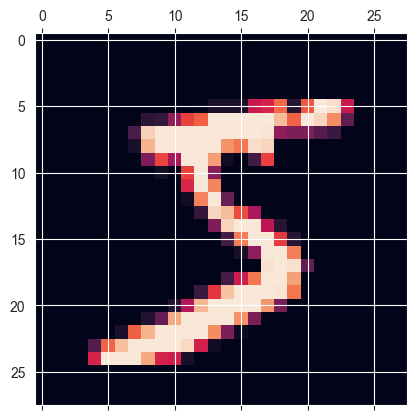

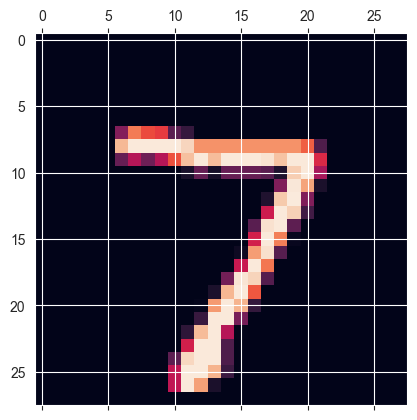

In [62]:
# Load mnist data 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Lenght of training samples
print('Lenght of training samples: ', len(x_train))

# Lenght of test samples
print('\nLenght of test samples: ', len(x_test))

# Shape 
print('\nShape: ', x_train[0].shape)
print('\n-----------------------------------------------------------------')

# Preprocess the data
x_train = (x_train.astype('float32') / 255).reshape(x_train.shape[0], 28, 28, 1)
x_test = (x_test.astype('float32') / 255).reshape(x_test.shape[0], 28, 28, 1)


y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

model = uwiz.models.StochasticSequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(UwizBernoulliDropout(0.5, stochastic_mode=StochasticMode()))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

model.summary()
plt.matshow(x_train[0])
plt.matshow(x_test[0])

## 3. Train

**Weights:** The values of all the trainable parameters in the model (learned during training).

**Saving the Inner Model:** We had a problem loading the entire model when using the Uncertainty Wizard's `StochasticSequential` model, possible that issue arises from trying to save this high-level wrapper directly. Instead, we are saving the `inner` model, which is the actual Keras model wrapped by the Uncertainty Wizard model.

Saving just the model weights with `model.inner.save_weights` saves the trainable parameters of the model, but not the architecture or any other configurations. This means that to load the model for evaluation or analysis, we will need to recreate the model architecture in code and then load the weights into it.

1. **Recreate the Model Architecture:** When you want to evaluate or analyze the model, you first need to recreate the exact same model architecture as the one you trained. This is done by calling the same function or code that was used to create the original model.
    
2. **Load the Saved Weights:** After recreating the model architecture, we load the saved weights into this model.

In [63]:
history = model.fit(x_train,
                    y_train,
                    validation_split=0.1,
                    batch_size=1000,
                    epochs=5,
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2),
                               tf.keras.callbacks.TensorBoard(log_dir='data/logs', histogram_freq=1)])

# Save the model
os.makedirs(os.path.dirname('data/model/model_weights.h5'), exist_ok=True)
model.inner.save_weights('data/model/model_weights.h5')
print("\nTraining completed, model weights saved")

Epoch 1/5
54/54 [==============================] - 3s 48ms/step - loss: 0.4588 - accuracy: 0.8649 - val_loss: 0.1220 - val_accuracy: 0.9670
Epoch 2/5
54/54 [==============================] - 2s 45ms/step - loss: 0.1179 - accuracy: 0.9645 - val_loss: 0.0752 - val_accuracy: 0.9792
Epoch 3/5
54/54 [==============================] - 2s 45ms/step - loss: 0.0778 - accuracy: 0.9766 - val_loss: 0.0565 - val_accuracy: 0.9835
Epoch 4/5
54/54 [==============================] - 2s 45ms/step - loss: 0.0654 - accuracy: 0.9794 - val_loss: 0.0536 - val_accuracy: 0.9870
Epoch 5/5
54/54 [==============================] - 2s 45ms/step - loss: 0.0580 - accuracy: 0.9817 - val_loss: 0.0479 - val_accuracy: 0.9873

Training completed, model weights saved


# Adversarial Training

`CategoricalCrossentropy(from_logits=True)`: This is the loss function used to compute the difference between the true labels and the predictions made by the model. The parameter from_logits=True indicates that the predictions are expected to be raw, unnormalized scores (logits), which the function will internally convert to probabilities using the softmax function.

`Mean(name='train_loss')`: This metric computes the mean of the losses incurred over each batch of training data, providing an overall measure of how well the model is performing during training.

`CategoricalAccuracy(name='train_accuracy')`: This metric calculates how often predictions match the one-hot encoded labels for multi-class classification tasks, effectively measuring the model's accuracy.

`projected_gradient_descent`: This function creates adversarial examples by applying small but intentional perturbations to the input data (x_batch), aiming to mislead the model. The perturbation size is controlled by args.eps, and the method iterates to refine these adversarial examples, using gradient descent with specified step size (0.01), number of iterations (40), and norm type (np.inf for infinity norm, which constrains the maximum change to any pixel).

TensorFlow's GradientTape is used for automatic differentiation, recording the operations performed during the forward pass to compute gradients during the backward pass. Here, it captures the computation of the model's predictions on the adversarial examples and the subsequent loss calculation.

In [49]:
optimizer = tf.keras.optimizers.legacy.Adadelta()
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
train_loss = Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

epochs = 5
batch = 1000
eps = 0.03
for epoch in range(epochs):
    print(f'Epoch: {epoch + 1}/{epochs}')
    
    # Initialize the progress bar
    progbar = Progbar(target=len(x_train) // batch, unit_name='batch')
    train_accuracy.reset_state()
    
    for batch_index, (x_batch, y_batch) in enumerate(tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch)):
        with tf.GradientTape() as tape:
            # Generate adversarial examples 
            x_batch_adv = projected_gradient_descent(model.inner, x_batch, eps, 0.01, 40, np.inf)
            
            adv_pred = model.inner(x_batch_adv, training=True)
            loss = loss_object(y_batch, adv_pred)
            
        gradients = tape.gradient(loss, model.inner.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.inner.trainable_variables))
        
        train_loss(loss)
        train_accuracy(y_batch, adv_pred)
        
        progbar.update(batch_index + 1, values=[("loss", train_loss.result()),
                                                ("accuracy", train_accuracy.result())])
        train_loss.reset_state()
        train_accuracy.reset_state()
        
os.makedirs(os.path.dirname('data/model/adv_model_weights.h5'), exist_ok=True)
model.inner.save_weights('data/model/adv_model_weights.h5')
print("\nAdversarial training completed, model weights saved")
        

Epoch: 1/5
60/60 [==============================] - 85s 1s/batch - loss: 0.2993 - accuracy: 0.8837
Epoch: 2/5
49/60 [=======================>......] - ETA: 15s - loss: 0.2794 - accuracy: 0.8912

KeyboardInterrupt: 

## 4. Plot Traning & Validation Accuracy and Loss 

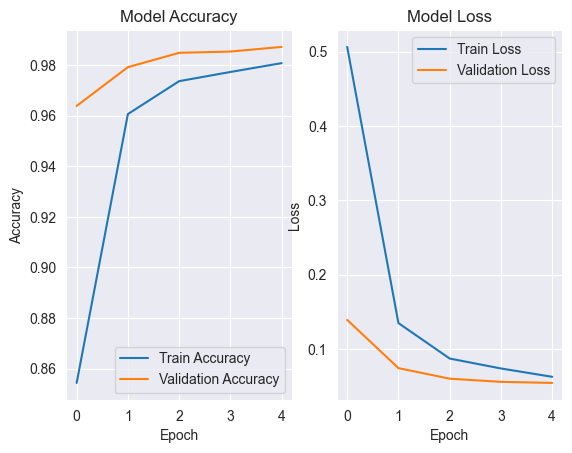

In [50]:
# Plot training & validation accuracy and loss
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 5. Evaluate Model

In [51]:
# Load the saved model weights
model.inner.load_weights('data/model/model_weights.h5')
print("Model weights loaded from disk")

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy', test_acc)
print('\nTest loss', test_loss)

# Making predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate the mean squared error
mse = tf.reduce_mean(tf.square(y_pred - y_test))
print(f'\nMSE: {mse:.4f}')


num_samples = 25
predictions = model.predict(x_test[:num_samples])
predicted_labels = np.argmax(predictions, axis=1)

Model weights loaded from disk
313/313 - 3s - loss: 0.0507 - accuracy: 0.9835 - 3s/epoch - 9ms/step

Test accuracy 0.9835000038146973

Test loss 0.0507088340818882
313/313 [==============================] - 1s 3ms/step

MSE: 0.0025
1/1 [==============================] - 0s 20ms/step


## 6. Adversarial

#### Cleverhans

https://github.com/cleverhans-lab/cleverhans

https://arxiv.org/pdf/1611.01236.pdf


**SparseCategoricalAccuray** is a way to check how often a model correctly predicts which category (class) each data point belongs to. It's "sparse" because the true categories are given as a single numbers like (0,1,2), not lists or vectors.

**SparseCategoricalCrossentropy** measures how well the model's predicted probabilities match the actual categories. It's like a score for the model's errors; the model tries to get this score as low as possible during training to make better predictions.



https://colab.research.google.com/github/andantillon/cleverhans/blob/master/tutorials/future/tf2/notebook_tutorials/mnist_fgsm_tutorial.ipynb#scrollTo=O4teWeVYvUGQ

In [52]:
if y_test.ndim > 1:
    y_test = np.argmax(y_test, axis=1)

test_accuracy = SparseCategoricalAccuracy()

# Evaluate on clean examples
for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
    predictions = model.predict(x_batch)
    test_accuracy.update_state(y_batch, predictions)
    
accuracy_clean = test_accuracy.result().numpy() * 100
print(f'\nTest accuracy on clean examples: {accuracy_clean}')

# Adversarial evaluation settings
eps = 0.3
test_accuracy_fgsm = SparseCategoricalAccuracy()
test_accuracy_pgd = SparseCategoricalAccuracy()

# Evaluate on adversarial examples (FGSM and PGD)
for x_batch, y_batch in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128):
    # FGSM examples
    x_adv_fgsm = fast_gradient_method(model.inner, x_batch, eps, np.inf)
    predictions_fgsm = model.predict(x_adv_fgsm)
    test_accuracy_fgsm.update_state(y_batch, predictions_fgsm)
    
    # PGD examples
    x_adv_pdg = projected_gradient_descent(model.inner, x_batch, eps, 0.01, 40, np.inf)
    predictions_pdg = model.predict(x_adv_pdg)
    test_accuracy_pgd.update_state(y_batch, predictions_pdg)
    
accuracy_fgsm = test_accuracy_fgsm.result().numpy() * 100
accuracy_pdg = test_accuracy_pgd.result().numpy() * 100

print(f'\nTest accuracy on FGSM adversarial examples: {accuracy_fgsm}')
print(f'Test accuracy on PDG adversarial examples: {accuracy_pdg}')

accuracies = [accuracy_clean, accuracy_fgsm, accuracy_pdg]

1/1 [==============================] - 0s 11ms/step

Test accuracy on clean examples: 98.35000038146973
1/1 [==============================] - 0s 9ms/step

Test accuracy on FGSM adversarial examples: 6.030000001192093
Test accuracy on PDG adversarial examples: 2.250000089406967


## 7. Plot Predictions, Confusion Matrix, Adversarial examples and Comparison between

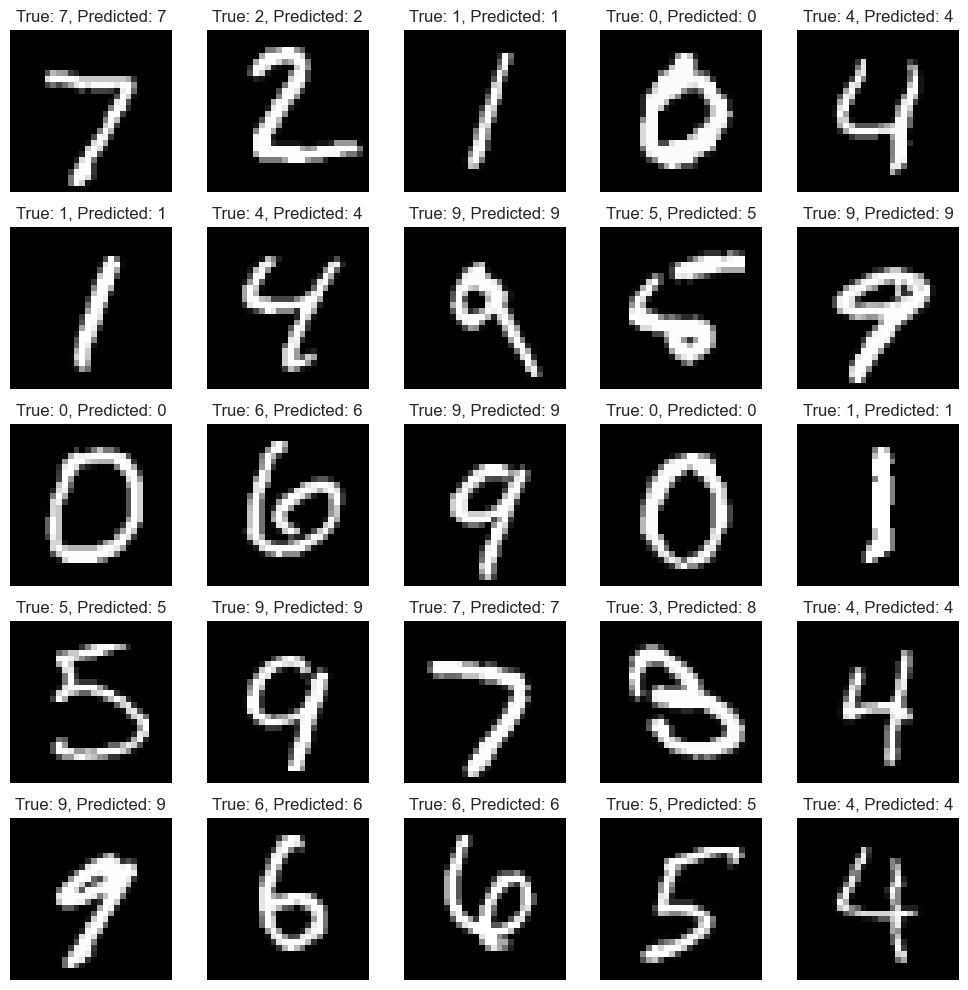

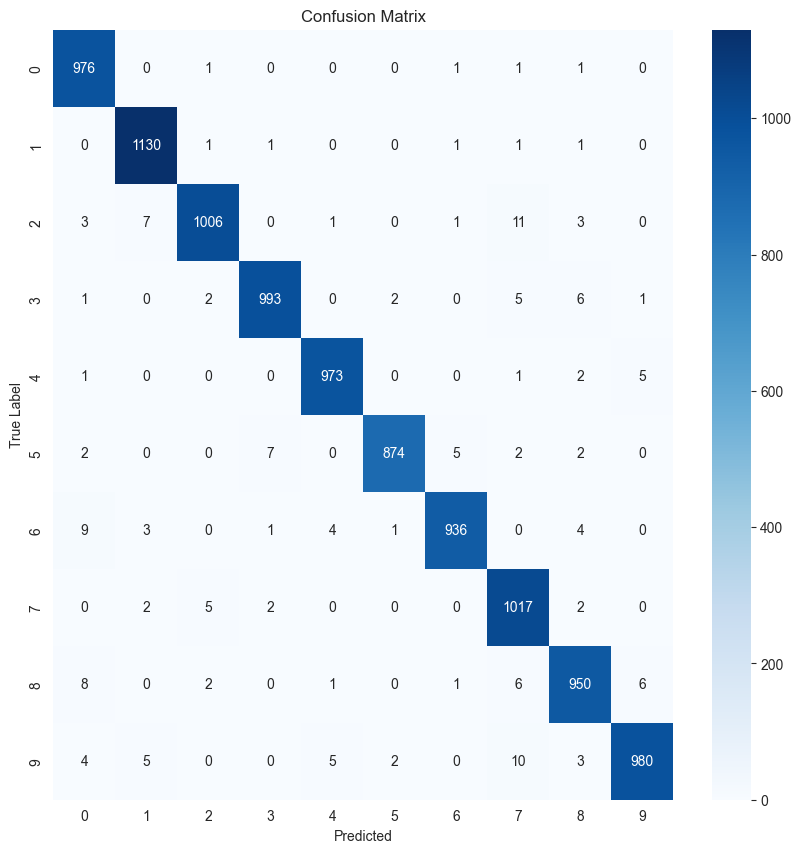

1/1 [==============================] - 0s 10ms/step


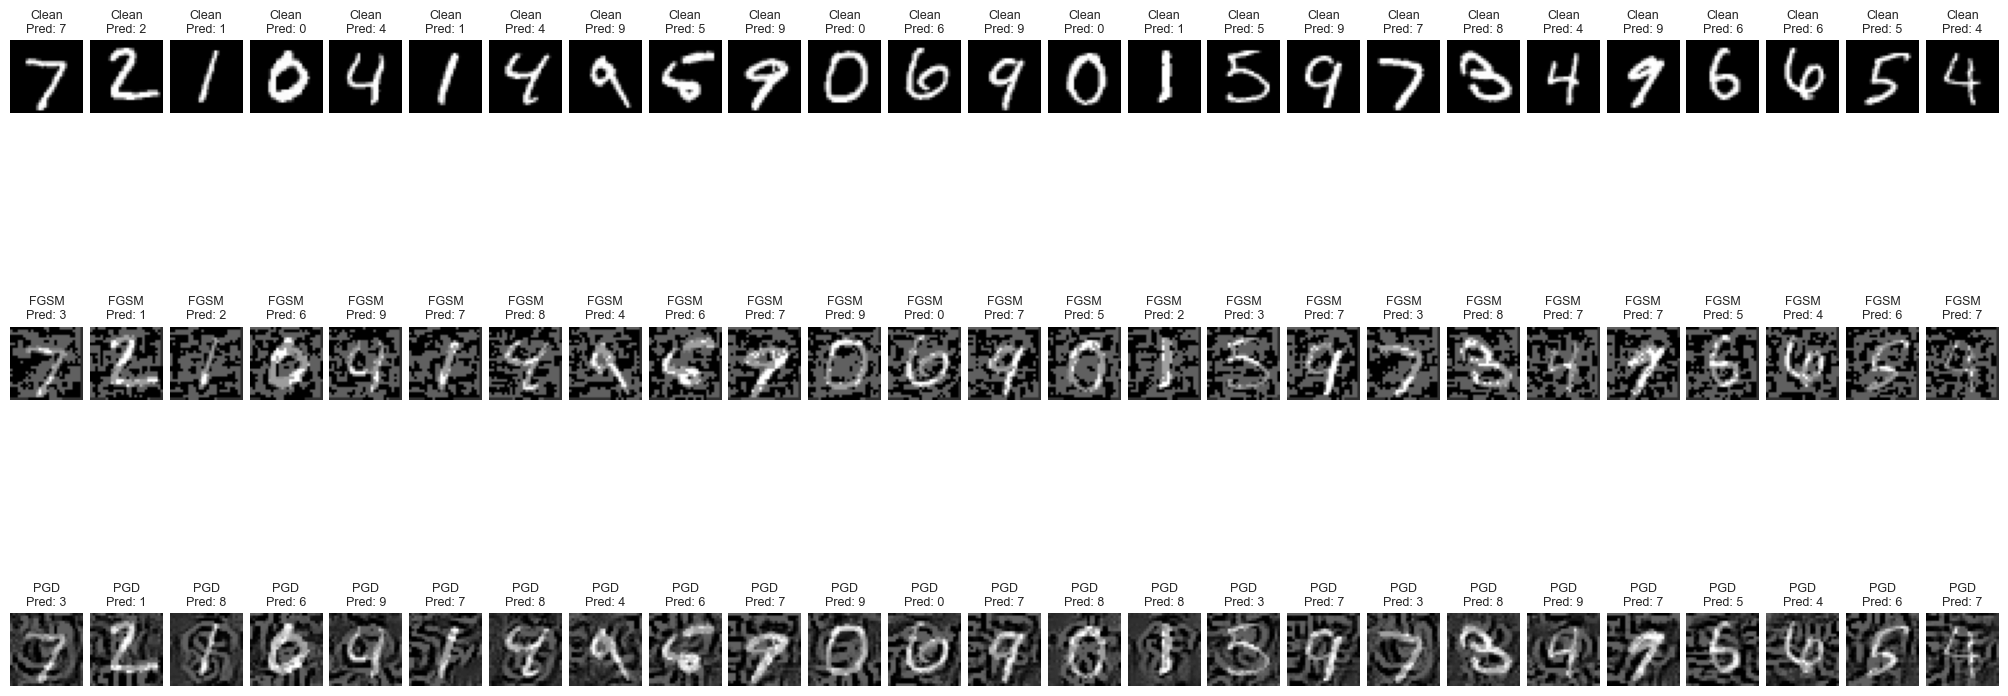

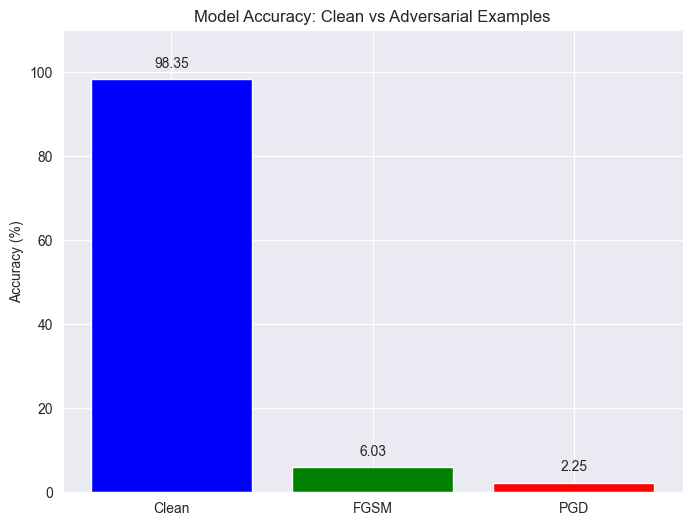

In [53]:
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'True: {y_true[i]}, Predicted: {predicted_labels[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

# Clean and Adversarial examples

#x_adv_fgsm = fast_gradient_method(model.inner, x_test[:num_samples], eps, np.inf)
#predictions_clean = np.argmax(model.predict(x_test[:num_samples]), axis=1)
#predictions_adv = np.argmax(model.predict(x_adv_fgsm), axis=1)

# Generate FGSM adversarial examples
x_adv_fgsm = fast_gradient_method(model.inner, x_test[:num_samples], eps, np.inf)
predictions_fgsm = np.argmax(model.predict(x_adv_fgsm), axis=1)

# Generate PGD adversarial examples
x_adv_pgd = projected_gradient_descent(model.inner, x_test[:num_samples], eps, 0.01, 40, np.inf)
predictions_pgd = np.argmax(model.predict(x_adv_pgd), axis=1)

plt.figure(figsize=(20, 10))
#plt.figure(figsize=(2 * num_samples, 6))

for i in range(num_samples):
    # Plot clean images
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(x_test[i], cmap='gray')  # If x_test is not already in 28x28, reshape is needed
        plt.title(f'Clean\nPred: {np.argmax(model.predict(x_test[i:i+1]), axis=1)[0]}', fontsize=9)
        plt.axis('off')

        # Plot FGSM adversarial images
        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(x_adv_fgsm[i], cmap='gray')
        plt.title(f'FGSM\nPred: {predictions_fgsm[i]}', fontsize=9)
        plt.axis('off')

        # Plot PGD adversarial images
        plt.subplot(3, num_samples, 2 * num_samples + i + 1)
        plt.imshow(x_adv_pgd[i], cmap='gray')
        plt.title(f'PGD\nPred: {predictions_pgd[i]}', fontsize=9)
        plt.axis('off')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
filename = f'pred_clean_vs_adv_{timestamp}.png'
plot_dir = './data/plots//evaluate'
os.makedirs(plot_dir, exist_ok=True)
plt.savefig(os.path.join(plot_dir, filename))

plt.show()


# Compare
plt.figure(figsize=(8, 6))
bar_positions = np.arange(len(accuracies))
plt.bar(bar_positions, accuracies, color=['blue', 'green', 'red'])
plt.xticks(bar_positions, labels=['Clean', 'FGSM', 'PGD'])
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy: Clean vs Adversarial Examples')
plt.ylim(0, 110)

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 2, f'{acc:.2f}', ha='center', va='bottom')
    
plt.show()

## 8. Analyze the Uncertainty

In the context of neural networks, uncertainty quantification is crucial for assessing the confidence of model predictions. There are two primary types of uncertainty:

1. **Aleatoric Uncertainty**: This type of uncertainty is inherent in the data. It arises from noise or variability in the data and can be captured directly from the data itself.
2. **Epistemic Uncertainty**: This uncertainty is due to the model's lack of knowledge. It can be reduced with more data or better models and is often where dropout-based methods come into play.


In [54]:
# Load the saved model weights 
model.inner.load_weights('data/model/model_weights.h5')
print("Model weights loaded from disk")

# Perform uncertainty quantification
quantifiers = ['pcs', 'mean_softmax']
results = model.predict_quantified(x_test,
                                    quantifier=quantifiers,
                                    batch_size=64,
                                    sample_size=32,
                                    verbose=1)


Model weights loaded from disk
157/157 [==============================] - 0s 3ms/step


## 9. Plots for Uncertainty Analysis

1. **Prediction Confidence Score (PCS):**
    
    - PCS is a measure of the model's confidence in its predictions. For classification tasks, this often translates to how high the softmax output is for the predicted class. A higher PCS indicates higher confidence in the prediction.
2. **Mean Softmax:**
    
    - Mean Softmax is typically used in stochastic models where multiple predictions are made for the same input (as in Monte Carlo Dropout). It refers to the average of the softmax outputs across all predictions for a given input. It can be interpreted as an averaged confidence level across multiple runs.

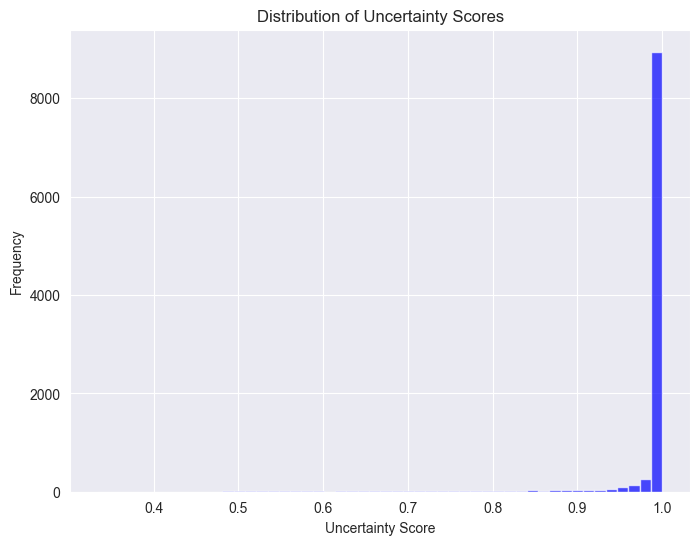

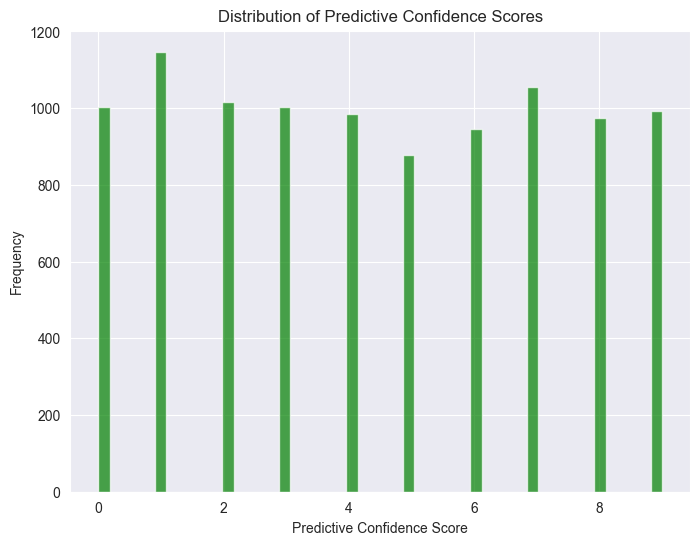

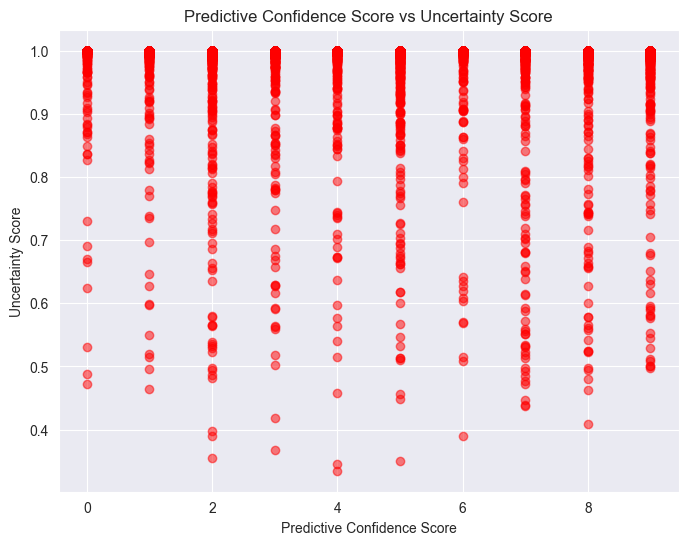

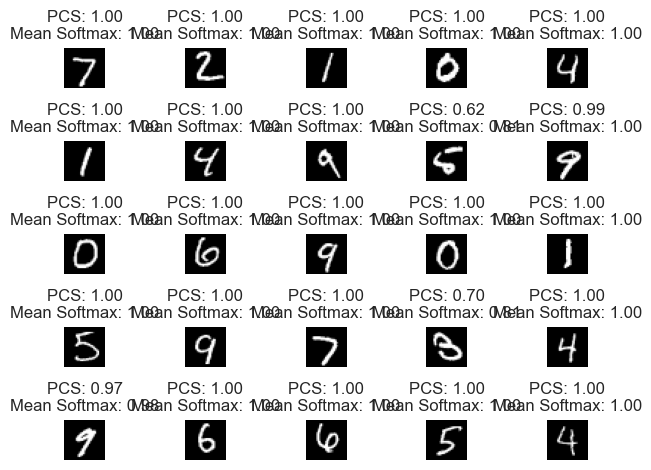

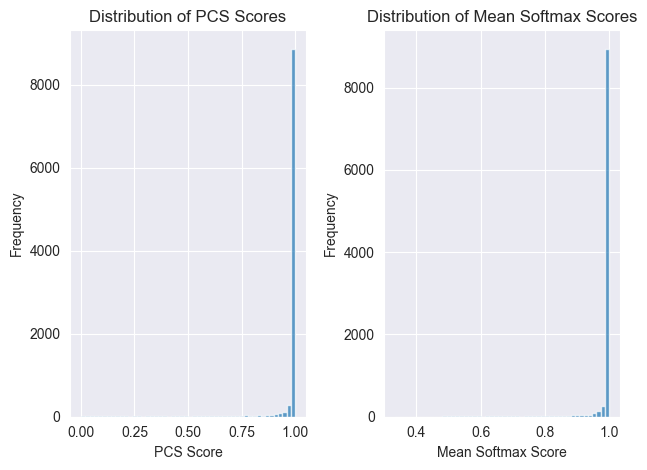

In [55]:
# Plot the uncertainty distribution
uncertainty_scores = results[1][1]
plt.figure(figsize=(8, 6))
plt.hist(uncertainty_scores, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Uncertainty Scores')
plt.xlabel('Uncertainty Score')
plt.ylabel('Frequency')
plt.show()

# Plot the predictive confidence score
confidence_scores = results[1][0]
plt.figure(figsize=(8, 6))
plt.hist(confidence_scores, bins=50, alpha=0.7, color='green')
plt.title('Distribution of Predictive Confidence Scores')
plt.xlabel('Predictive Confidence Score')
plt.ylabel('Frequency')
plt.show()

# Plot the predictive confidence score vs uncertainty score
plt.figure(figsize=(8, 6))
plt.scatter(confidence_scores, uncertainty_scores, alpha=0.5, color='red')
plt.title('Predictive Confidence Score vs Uncertainty Score')
plt.xlabel('Predictive Confidence Score')
plt.ylabel('Uncertainty Score')
plt.show()

# Plot PCS and Mean Softmax scores for a subset of the test set data  
#qualitative, visual correlation between each image and its corresponding scores.
num_samples = 25
pcs_scores, mean_softmax_scores = results[0][1], results[1][1]
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'PCS: {pcs_scores[i]:.2f}\nMean Softmax: {mean_softmax_scores[i]:.2f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Plot distribution of PCS and Mean Softmax scores
pcs_scores = results[0][1]
mean_softmax_scores = results[1][1]
plt.subplot(1, 2, 1)
plt.hist(pcs_scores, bins=50, alpha=0.7)
plt.xlabel('PCS Score')
plt.ylabel('Frequency')
plt.title('Distribution of PCS Scores')
plt.subplot(1, 2, 2)
plt.hist(mean_softmax_scores, bins=50, alpha=0.7)
plt.xlabel('Mean Softmax Score')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Softmax Scores')
plt.tight_layout()
plt.show()


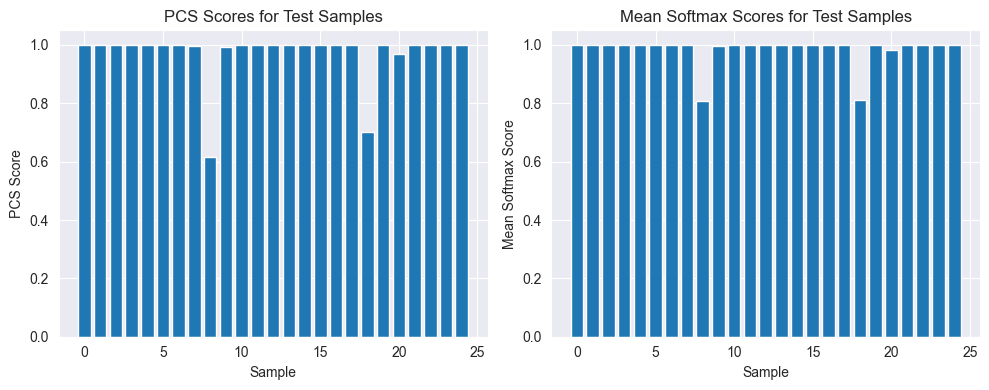

In [56]:
pcs_scores = results[0][1][:num_samples]  
mean_softmax_scores = results[1][1][:num_samples]

# Plot PCS scores
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(num_samples), pcs_scores)
plt.xlabel('Sample')
plt.ylabel('PCS Score')
plt.title('PCS Scores for Test Samples')

# Plot Mean Softmax scores
plt.subplot(1, 2, 2)
plt.bar(range(num_samples), mean_softmax_scores)
plt.xlabel('Sample')
plt.ylabel('Mean Softmax Score')
plt.title('Mean Softmax Scores for Test Samples')

plt.tight_layout()
plt.show()

(10000, 28, 28, 1)


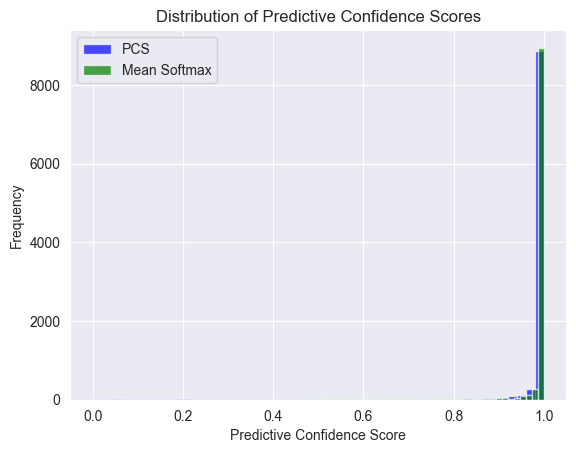

In [58]:
print(x_test.shape)
pcs_predictions = results[0][0]
pcs_confidences = results[0][1]
mean_softmax_predictions = results[1][0]
mean_softmax_confidences = results[1][1]


plt.hist(pcs_confidences, bins=50, alpha=0.7, color='blue', label='PCS')
plt.hist(mean_softmax_confidences, bins=50, alpha=0.7, color='green', label='Mean Softmax')
plt.title('Distribution of Predictive Confidence Scores')
plt.xlabel('Predictive Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# Add entropy based uncertainty quantification

In [ ]:
%load_ext tensorboard
%tensorboard --logdir data/logs

# Addtional arguments

- On evaluate: add filepath, list of matrix, list of attacks (attack on another pipeline after training the model), take eps value as parameter on evaluation,
- if another model is added, then add parameter for it. 


### Generate an html raport for jenkins.